<a href="https://colab.research.google.com/github/Zhen-Miao/PIC-snATAC/blob/main/vignettes/Key_result_1_High_density_count_and_open_probability_correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Key results 1: High-density count and open probability correlation

## Content and Datasets
In this notebook, we aim to reproduce the results on examining the correlation between high-density count and open probability. We will use the human cell line mixture data from (Granja et al., Nature Genetics 2021) publication. The data are publicly available under GEO accession number [GSE162690](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE162690). Specifically, please download the following file and upload it to this worksheet to run the analysis

```
GSE162690_CellLine_LowLoading-PeakMatrix-SE.rds.gz
```



## 1. Install packages

In [ ]:
install.packages(c('viridisLite','ggplot2','RColorBrewer','dplyr','reshape2'))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘plyr’, ‘Rcpp’




In [ ]:
install.packages('data.table')
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("SummarizedExperiment")
devtools::install_github("Zhen-Miao/PIC-snATAC")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.17 (BiocManager 1.30.20), R 4.3.0 (2023-04-21)

Installing package(s) 'BiocVersion', 'SummarizedExperiment'

also installing the dependencies ‘zlibbioc’, ‘bitops’, ‘matrixStats’, ‘XVector’, ‘RCurl’, ‘GenomeInfoDbData’, ‘MatrixGenerics’, ‘GenomicRanges’, ‘Biobase’, ‘BiocGenerics’, ‘S4Vectors’, ‘IRanges’, ‘GenomeInfoDb’, ‘S4Arrays’, ‘DelayedArray’


Old packages: 'bit', 'bslib', 'devtools', 'digest', 'gert', 'highr', 'isoband',
  'jsonlite', 'knitr', 'pkgload', 'rmarkdown', 'roxygen2', 'sys', 'tidyverse',
  'whisker', 'boot', 'foreign'




Skipping 4 packages not available: GenomeInfoDb, Rsamtools, GenomicRanges, IRanges



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpiFsOFG/remotes17937fa0307/Zhen-Miao-PIC-snATAC-b0f6fdc/DESCRIPTION’ ... OK
* preparing ‘PICsnATAC’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘PICsnATAC_0.2.1.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in i.p(...):
“installation of package ‘/tmp/RtmpiFsOFG/file1791f3c0788/PICsnATAC_0.2.1.tar.gz’ had non-zero exit status”


## 2. Load packages

In [ ]:
library('SummarizedExperiment')
library('viridisLite')
library('ggplot2')
library("RColorBrewer")

## 3. Load data and conduct basic check

The human cell line dataset is saved as a SummarizedExperiment object, let us first load it via readRDS() function


In [ ]:
low = readRDS('GSE162690_CellLine_LowLoading-PeakMatrix-SE.rds')

The cell types are stored in @colData. We need to exclude ambigious clusters (AMB) and doublets (DBL), and we will only examine the ten major cell types

In [ ]:
cell_types = low@colData$DemuxletClassify2
print(table(cell_types))

cell_types
   293T     AMB     DBL GM12878    HeLa  HT1080  Jurkat    K562  MCF10A    MCF7 
   2160       5     336    1293     696     946     762     462     534     712 
    T24    THP1 
   2966     301 


In [ ]:
## cell types to be included in the study
ctypes = unique(low@colData$DemuxletClassify2)
ctypes = setdiff(ctypes, c('DBL', 'AMB'))

The peak-by-cell ***insertion*** count matrix can be obtained using the following command

In [ ]:
str(low@assays$data@listData$PeakMatrix)

Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:44837096] 23 55 79 82 85 89 98 101 102 110 ...
  ..@ p       : int [1:11174] 0 19679 39075 61829 84103 100338 121198 138736 147797 169273 ...
  ..@ Dim     : int [1:2] 336098 11173
  ..@ Dimnames:List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:11173] "CellLine_Low#CTAGGGCAGGTTTCTG-1" "CellLine_Low#GCTCGAGGTCTAACCA-1" "CellLine_Low#CCAGAATCACGCGCAT-1" "CellLine_Low#GTCACTCAGGGCATTG-1" ...
  ..@ x       : num [1:44837096] 2 1 1 1 1 2 1 1 2 2 ...
  ..@ factors : list()


We can take a look at the count frequency. There are more '2's in the data than the frequency of '1', a hallmark of insertion-based counting method. The maximum count was capped at 4 in this matrix by the ArchR method. We note that such a ceiling step does not affect our analysis.

In [ ]:
count_freq = table(low@assays$data@listData$PeakMatrix@x)

print(count_freq)


       1        2        3        4 
17702639 24946650  1142081  1045726 


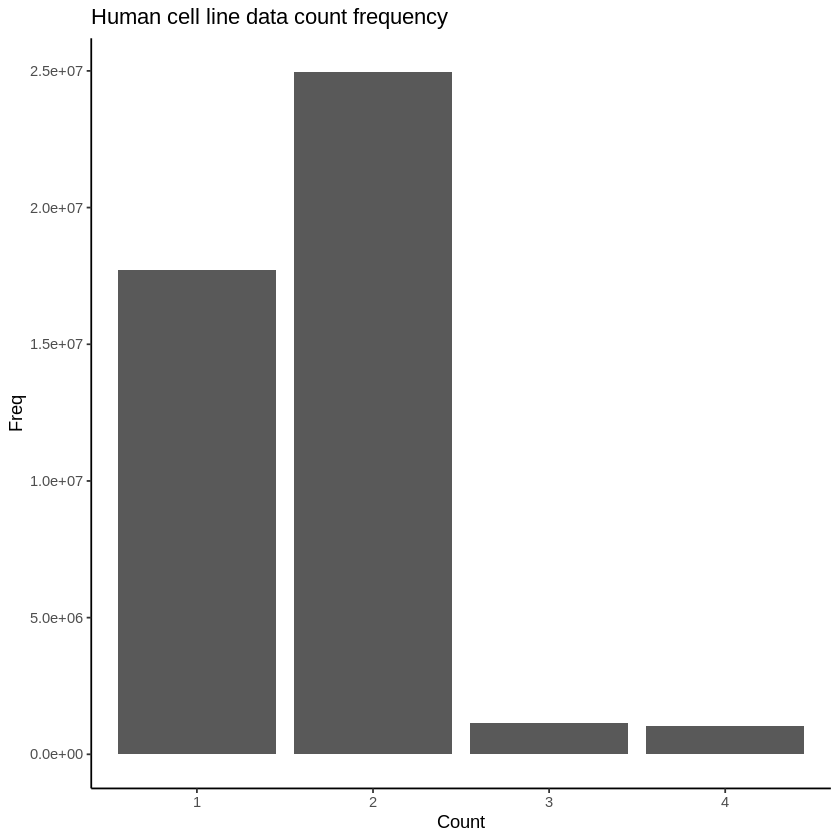

In [ ]:
cf = as.data.frame(count_freq)
ggplot(cf)+
  geom_col(aes(x = Var1, y = Freq))+
  xlab('Count')+ggtitle('Human cell line data count frequency')+
  theme_classic()

## Question 1. Is there quantitative information in snATAC-seq data?
To answer this question, we first check at the **fragment** level, whether observing two fragments in a single cell indicates overall higher chance of accessibility for the same cell type (cell line). Since the counts 2 and 1 mainly represent the boundary phasing issue, we estimated the probability of observing a count greater than or equal to 3, given the observation of a non-zero count, image.png (For more details, please read our manuscript)

In [ ]:
## obtain data matrix 
pmat_cell_line <- low@assays$data@listData$PeakMatrix

## binarize and save as a different object
pmat_cell_linebin <- pmat_cell_line
pmat_cell_linebin@x <- rep(1, times = length(pmat_cell_linebin@x))


In [ ]:
pmat_cell_line@x[pmat_cell_line@x <= 2] = 1
pmat_cell_line@x[pmat_cell_line@x >= 3] = 2

## proportion_counts_more_than_1 stands for the proportion of counts 
## that are greater than one fragment (two insertions)
proportion_counts_more_than_1 <- matrix(nrow = dim(pmat_cell_line)[1], ncol = length(ctypes))
colnames(proportion_counts_more_than_1) <- ctypes

## n_cell_acc_prop stands for the number of cells being acessible
n_cell_acc_prop <- proportion_counts_more_than_1 


In [ ]:
## compute several quantities
for(jj in ctypes){
  pmat_cell_line1 = pmat_cell_line[,low@colData$DemuxletClassify2 == jj]
  pmat_cell_linebin1 = pmat_cell_linebin[,low@colData$DemuxletClassify2 == jj]
  
  n_cell_acc <- Matrix::rowSums(pmat_cell_linebin1)
  n_counts_more_than_1 <- Matrix::rowSums(pmat_cell_line1) - n_cell_acc
  proportion_counts_more_than_1[,jj] <- n_counts_more_than_1 / n_cell_acc
  n_cell_acc_prop[,jj] <- n_cell_acc / dim(pmat_cell_line1)[2]
}

The Spearman correlation was computed between the open probability and frequency of counts greater than three.

In [ ]:
defaultW <- getOption("warn") 
options(warn = -1) 
corr_across_features <- vector(length = dim(pmat_cell_line)[1])
for(i in 1:dim(pmat_cell_line)[1]){
  corr_across_features[i] = cor(n_cell_acc_prop[i,], proportion_counts_more_than_1[i,],
                                method = 'spearman')
}

options(warn = defaultW)

We then look at the median correlation and the number of positive and negative correlations

In [ ]:
print(quantile(corr_across_features,na.rm = T))

        0%        25%        50%        75%       100% 
-0.7294867  0.3742613  0.5276493  0.7006490  0.9969651 


In [ ]:
print(sum(corr_across_features < 0 , na.rm = T))
print(sum(corr_across_features > 0 , na.rm = T)) 

[1] 2535
[1] 53169


We then plot the distribution of correlation values. 



Warning message:
“Removed 280365 rows containing non-finite values (`stat_bin()`).”


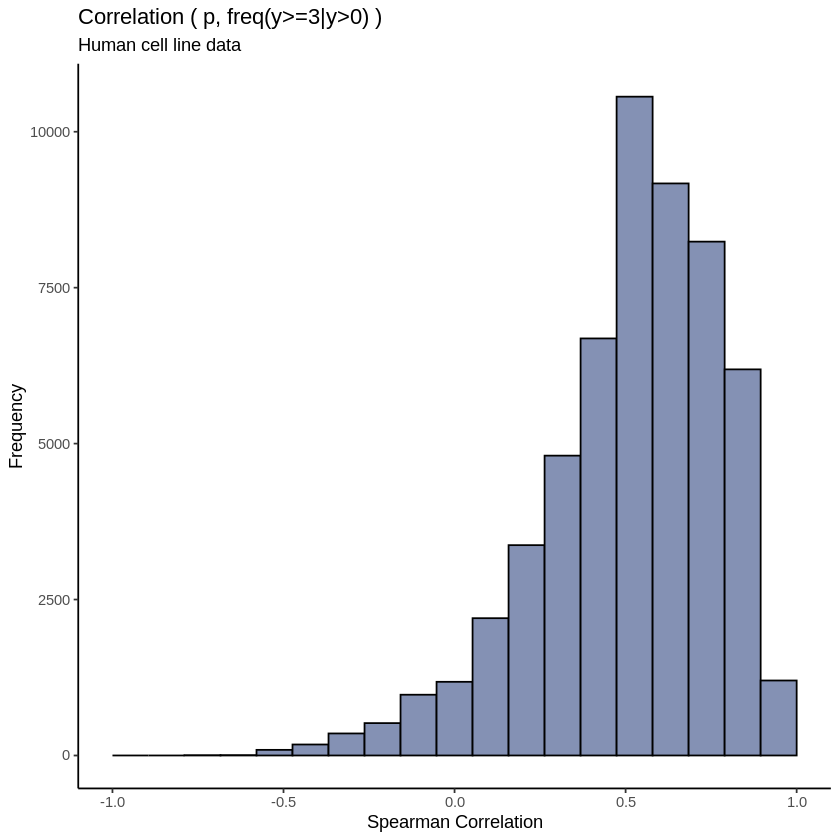

In [ ]:
library('ggplot2')
df = data.frame(corr = corr_across_features)

p1 = ggplot(df, aes(x = corr)) + 
  geom_histogram(bins = 20, color='black', fill="#8491b4") + 
  xlim(-1,1)+
  # scale_x_discrete(drop = FALSE, limits = c(-1,1))+
  ggtitle("Correlation ( p, freq(y>=3|y>0) )",subtitle = 'Human cell line data') +
  xlab("Spearman Correlation") +
  ylab('Frequency')+
  theme_classic()

plot(p1)

## *Note NA values arise because certain peaks have zero proportion of 
## accessibility, and thus high density proportion cannot be computed. 
## We will only look at the distribution with no NA values.

## results intepretation
The above figure implies that for most of the peaks, there is a strong positive correlation between open probability *p* and the frequency of high-density count (>2 fragments or >3 insertions), suggesting that there is quantitative information in single cell accessibility. Please see more discussion in the manuscript. 

## Question 2. Whether there is difference between 1 and 2 for insertion-based counting?

To examine whether the insertion counts 1 vs 2 contain different information, we followed the same idea as above, computed the probability of observing a count equal to 2 given the count being 1 or 2,
image.png and examined its correlation with open probability.

In [ ]:
library('Matrix')
pmat_cell_line <- low@assays$data@listData$PeakMatrix

## we retain the 
pmat_cell_line@x[pmat_cell_line@x >= 3] = 0
pmat_cell_line = drop0(pmat_cell_line)
pmat_cell_linebin <- pmat_cell_line
pmat_cell_linebin@x <- rep(1, times = length(pmat_cell_linebin@x))



Attaching package: ‘Matrix’


The following object is masked from ‘package:S4Vectors’:

    expand




In [ ]:
## compute several quantities
for(jj in ctypes){
  pmat_cell_line1 = pmat_cell_line[,low@colData$DemuxletClassify2 == jj]
  pmat_cell_linebin1 = pmat_cell_linebin[,low@colData$DemuxletClassify2 == jj]
  
  n_cell_acc <- Matrix::rowSums(pmat_cell_linebin1)
  n_counts_more_than_1 <- Matrix::rowSums(pmat_cell_line1) - n_cell_acc
  proportion_counts_more_than_1[,jj] <- n_counts_more_than_1 / n_cell_acc
  n_cell_acc_prop[,jj] <- n_cell_acc / dim(pmat_cell_line1)[2]
}

In [ ]:
defaultW <- getOption("warn") 
options(warn = -1) 
corr_across_features <- vector(length = dim(pmat_cell_line)[1])
for(i in 1:dim(pmat_cell_line)[1]){
  corr_across_features[i] = cor(n_cell_acc_prop[i,], proportion_counts_more_than_1[i,],
                                method = 'spearman')
}

options(warn = defaultW)

We then look at the median correlation and the number of positive and negative correlations

In [ ]:
print(quantile(corr_across_features,na.rm = T))

        0%        25%        50%        75%       100% 
-0.9604908 -0.2066879  0.0711159  0.3454545  0.9848070 


Warning message:
“Removed 277182 rows containing non-finite values (`stat_bin()`).”


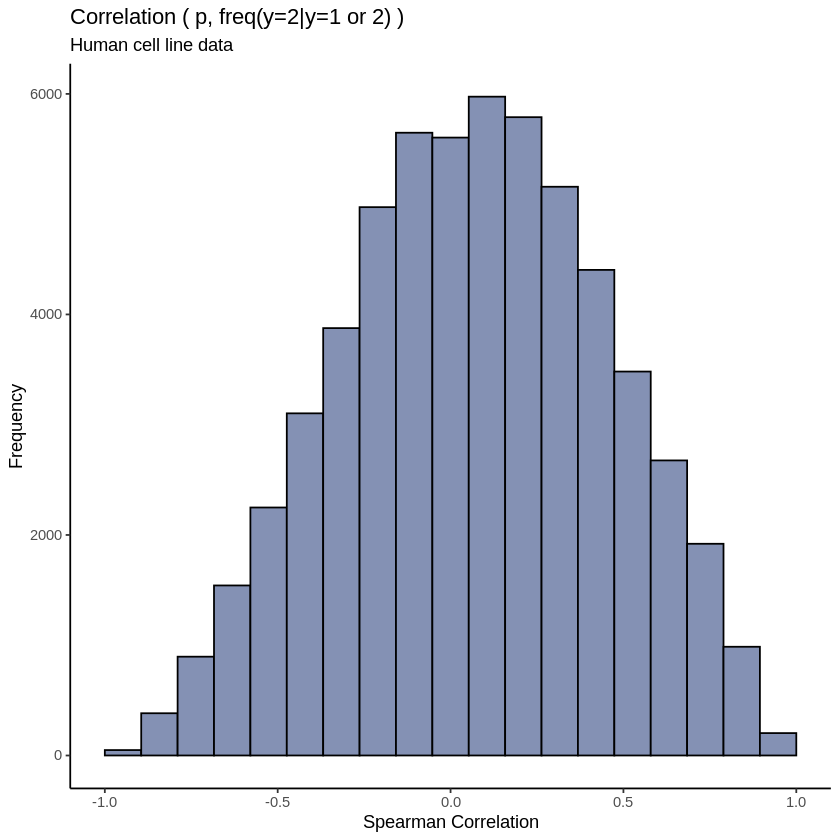

In [ ]:
df2 = data.frame(corr = corr_across_features)

p2 = ggplot(df2, aes(x = corr)) + 
  geom_histogram(bins = 20, color='black', fill="#8491b4") + 
  xlim(-1,1)+
  # scale_x_discrete(drop = FALSE, limits = c(-1,1))+
  ggtitle("Correlation ( p, freq(y=2|y=1 or 2) )",subtitle = 'Human cell line data') +
  xlab("Spearman Correlation") +
  ylab('Frequency')+
  theme_classic()

plot(p2)

## *Note NA values arise because certain peaks have zero proportion of 
## accessibility, and thus high density proportion cannot be computed. 
## We will only look at the distribution with no NA values.

## results intepretation
The above figure implies that unlike the Q2, it appears that whether we see a higher frequency of 2 vs 1, there is usually not different level of open probability for the cell type. This suggests that we usually could not obtain quantitative information from the insertion counting by distinguishing 1 and 2. Please see more discussion in the manuscript. 